In [1]:
import torch
import torchvision as tv
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as Fnn
import os
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid as makeGrid
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "drive/MyDrive/MLstuff/kaggle.json"

! pip install kaggle --quiet

! mkdir ~/.kaggle
! cp drive/MyDrive/MLstuff/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d masouduut94/digikala-color-classification



! mkdir kaggle_data
! unzip {"digikala-color-classification" + ".zip"} -d kaggle_data

# Unmount your Google Drive
drive.flush_and_unmount()

In [3]:
from PIL import Image
from pathlib import Path
import numpy as np

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
device = get_default_device()

device

device(type='cuda')

In [6]:
def accuracy(outputs, labels):
    _, predictions = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = Fnn.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = Fnn.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [7]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [8]:
def showBatch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.imshow(makeGrid(images, nrow = 16).permute(1, 2, 0))
        ax.axis('off')
        break

In [9]:
def showSample(img, label):
    print("Label:", dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

In [10]:
def plotAccuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')


In [11]:
def plotLosses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [12]:
def predictImage(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [13]:
path = os.getcwd()
path

'/content'

In [14]:
data_path = path + '/kaggle_data/train'

sorting_classes = os.listdir(data_path)

In [15]:
print(sorting_classes)

['brown', 'red', 'grey', 'pink', 'white', 'blue', 'yellow', 'orange', 'purple', 'black', 'green', 'silver']


In [16]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_path, transform = transformations)


In [17]:
class AlexNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network =  torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
        self.network.classifier = nn.Sequential(
            nn.Linear(9216,64),
            nn.Linear(64,len(dataset.classes))
            )

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = AlexNet()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 292MB/s]


Label: purple


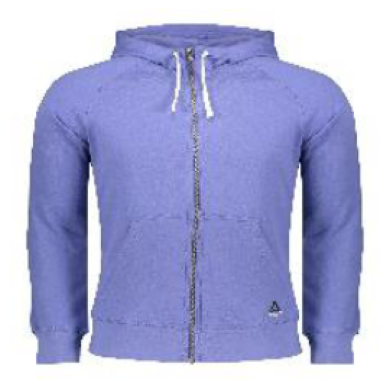

In [23]:
image, label = dataset[3889]

showSample(image,label)

In [24]:
torch.manual_seed(42)

In [25]:
train, val, test = random_split(dataset, [0.6, 0.1, 0.3])
print('size of training set: ', len(train),'size of validation set: ', len(val),'size of test set: ', len(test))

size of training set:  3744 size of validation set:  624 size of test set:  1871


In [26]:
batch_size = 32

In [27]:
train_dataloader = DataLoader(train, batch_size,shuffle=True,
                               num_workers=4,pin_memory=True)
val_dataloader = DataLoader(val, batch_size*2, num_workers=4,pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
showBatch(train_dataloader)

In [28]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

In [29]:
model = to_device(AlexNet(),device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [30]:
evaluate(model,val_dataloader)

{'val_loss': 2.474505662918091, 'val_acc': 0.14531250298023224}

In [ ]:
num_epochs = 5

optimization = torch.optim.Adam

lr = 5.5e-5

history = fit(num_epochs,lr,model,train_dataloader,val_dataloader,optimization)

Epoch 1: train_loss: 2.1597, val_loss: 2.0341, val_acc: 0.6715
Epoch 2: train_loss: 1.9997, val_loss: 1.9827, val_acc: 0.7461
Epoch 3: train_loss: 1.9501, val_loss: 1.9637, val_acc: 0.7732
Epoch 4: train_loss: 1.9238, val_loss: 1.9478, val_acc: 0.8050
Epoch 5: train_loss: 1.9177, val_loss: 1.9426, val_acc: 0.8041


In [31]:
num_epochs = 20

optimization = torch.optim.Adam

lr = 5.5e-5

history = fit(num_epochs,lr,model,train_dataloader,val_dataloader,optimization)

Epoch 1: train_loss: 2.0863, val_loss: 1.9284, val_acc: 0.6245
Epoch 2: train_loss: 1.8647, val_loss: 1.8391, val_acc: 0.7188
Epoch 3: train_loss: 1.8289, val_loss: 1.7938, val_acc: 0.7552
Epoch 4: train_loss: 1.7954, val_loss: 1.7917, val_acc: 0.7766
Epoch 5: train_loss: 1.7765, val_loss: 1.7936, val_acc: 0.7599
Epoch 6: train_loss: 1.7624, val_loss: 1.7761, val_acc: 0.7896
Epoch 7: train_loss: 1.7483, val_loss: 1.7762, val_acc: 0.7859
Epoch 8: train_loss: 1.7365, val_loss: 1.8121, val_acc: 0.7375
Epoch 9: train_loss: 1.7342, val_loss: 1.7684, val_acc: 0.7792
Epoch 10: train_loss: 1.7215, val_loss: 1.7816, val_acc: 0.7693
Epoch 11: train_loss: 1.7112, val_loss: 1.7668, val_acc: 0.8052
Epoch 12: train_loss: 1.7110, val_loss: 1.7731, val_acc: 0.7885
Epoch 13: train_loss: 1.6979, val_loss: 1.7831, val_acc: 0.8083
Epoch 14: train_loss: 1.7000, val_loss: 1.7889, val_acc: 0.7823
Epoch 15: train_loss: 1.6897, val_loss: 1.7690, val_acc: 0.7943
Epoch 16: train_loss: 1.6858, val_loss: 1.7800, v

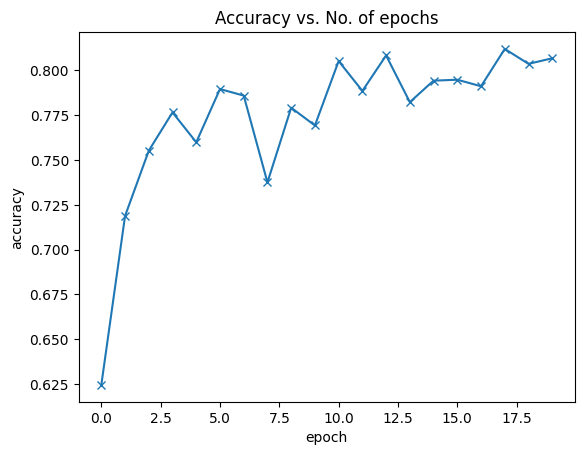

In [32]:
plotAccuracies(history)

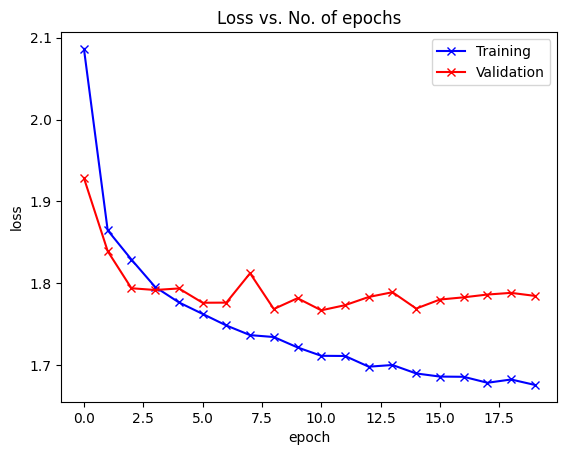

In [33]:
plotLosses(history)

Label: black , Predicted: black


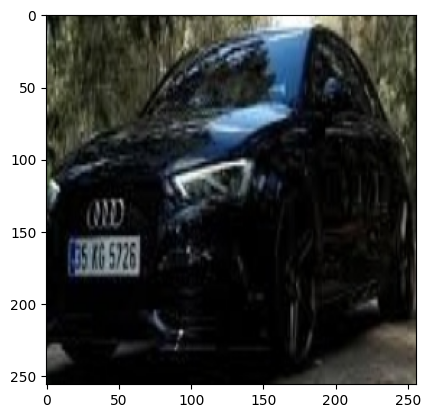

In [ ]:
test_id = np.random.randint(0,len(test))
image, label = test[test_id]
plt.imshow(image.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predictImage(image, model))


In [ ]:
def predict_external_image(image_name):
    image = Image.open(Path('./input/cars-colors/external_image/' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predictImage(example_image, model) + ".")

The image resembles black.


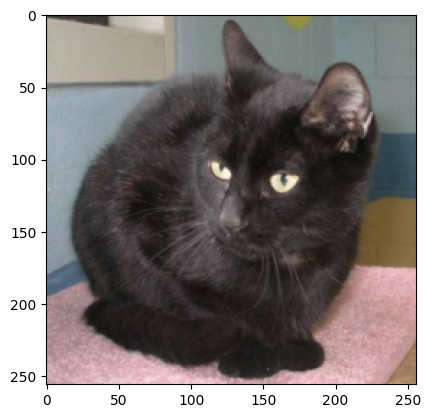

In [ ]:
predict_external_image('black1.jpg')

In [ ]:
torch.save(model.state_dict(), Path('./torch/resNetCarColors'))

In [ ]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(96)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(256)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(6 * 6 * 256, 4096)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.4)
        self.bn4 = nn.BatchNorm1d(4096)

        self.fc2 = nn.Linear(4096, 4096)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.4)
        self.bn5 = nn.BatchNorm1d(4096)

        self.fc3 = nn.Linear(4096, 1000)
        self.relu8 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(0.4)
        self.bn6 = nn.BatchNorm1d(1000)

        self.fc4 = nn.Linear(1000, 12)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool3(x)
        x = self.bn3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu6(x)
        x = self.dropout1(x)
        x = self.bn4(x)

        x = self.fc2(x)
        x = self.relu7(x)
        x = self.dropout2(x)
        x = self.bn5(x)

        x = self.fc3(x)
        x = self.relu8(x)
        x = self.dropout3(x)
        x = self.bn6(x)

        x = self.fc4(x)
        x = self.softmax(x)

        return x

# Create an instance of the AlexNet model
model = AlexNet()
